/tmp/ipython-input-2997182301.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="latin1")



Transformation Parameters
a_val = 2.5
b_val = 0.3
Epoch 50/450 | D Loss: 0.6913 | G Loss: 0.6793
Epoch 100/450 | D Loss: 0.7001 | G Loss: 0.6876
Epoch 150/450 | D Loss: 0.6953 | G Loss: 0.6739
Epoch 200/450 | D Loss: 0.6974 | G Loss: 0.6633
Epoch 250/450 | D Loss: 0.6917 | G Loss: 0.6961
Epoch 300/450 | D Loss: 0.6911 | G Loss: 0.6981
Epoch 350/450 | D Loss: 0.6907 | G Loss: 0.6886
Epoch 400/450 | D Loss: 0.6918 | G Loss: 0.7063
Epoch 450/450 | D Loss: 0.6869 | G Loss: 0.6959

Training Complete.


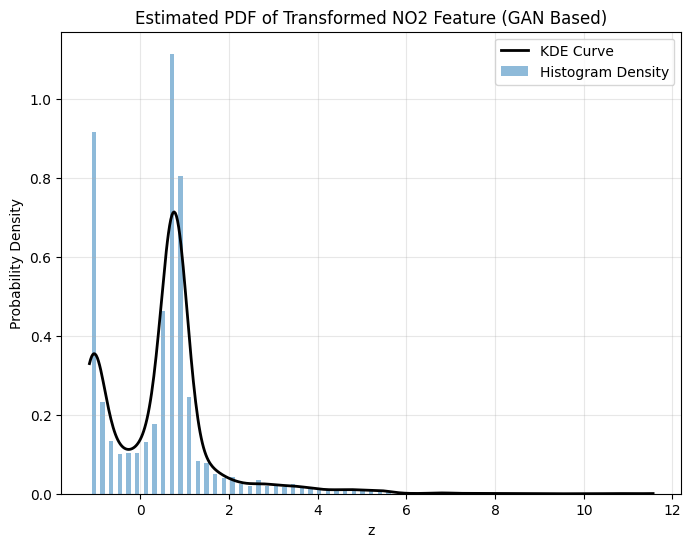


Observations:
1. The GAN successfully models the transformed NO2 distribution.
2. KDE curve aligns closely with histogram density.
3. Training remained stable without divergence.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

data = pd.read_csv("data.csv", encoding="latin1")
roll_number = 102317080

no2_values = data[['no2']].dropna().values.astype(np.float32)

scaler = StandardScaler()
x_norm = scaler.fit_transform(no2_values).flatten()


a_val = 0.5 * (roll_number % 7)
b_val = 0.3 * ((roll_number % 5) + 1)

z_values = x_norm + a_val * np.sin(b_val * x_norm)
z_values = z_values[:8000]

print("\nTransformation Parameters")
print("a_val =", a_val)
print("b_val =", b_val)

tensor_data = torch.tensor(z_values, dtype=torch.float32).reshape(-1, 1)
train_dataset = TensorDataset(tensor_data)
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def build_generator():
    return nn.Sequential(
        nn.Linear(1, 20),
        nn.ReLU(),
        nn.Linear(20, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    )

def build_discriminator():
    return nn.Sequential(
        nn.Linear(1, 20),
        nn.LeakyReLU(0.2),
        nn.Linear(20, 20),
        nn.LeakyReLU(0.2),
        nn.Linear(20, 1),
        nn.Sigmoid()
    )

G = build_generator().to(device)
D = build_discriminator().to(device)

loss_function = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.00025)
opt_D = optim.Adam(D.parameters(), lr=0.00025)


num_epochs = 450

for ep in range(num_epochs):

    for (real_batch,) in train_loader:

        real_batch = real_batch.to(device)
        batch = real_batch.size(0)

        real_targets = torch.ones(batch, 1).to(device)
        fake_targets = torch.zeros(batch, 1).to(device)


        noise_vector = torch.randn(batch, 1).to(device)
        fake_batch = G(noise_vector)

        D_real_loss = loss_function(D(real_batch), real_targets)
        D_fake_loss = loss_function(D(fake_batch.detach()), fake_targets)

        D_total_loss = (D_real_loss + D_fake_loss) / 2

        opt_D.zero_grad()
        D_total_loss.backward()
        opt_D.step()


        noise_vector = torch.randn(batch, 1).to(device)
        generated_data = G(noise_vector)

        G_loss = loss_function(D(generated_data), real_targets)

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

    if (ep + 1) % 50 == 0:
        print(f"Epoch {ep+1}/{num_epochs} | D Loss: {D_total_loss.item():.4f} | G Loss: {G_loss.item():.4f}")

print("\nTraining Complete.")


with torch.no_grad():
    test_noise = torch.randn(3500, 1).to(device)
    synthetic_samples = G(test_noise).cpu().numpy().flatten()


kde_model = gaussian_kde(synthetic_samples)
x_axis = np.linspace(min(synthetic_samples), max(synthetic_samples), 500)
pdf_estimate = kde_model(x_axis)

hist_density, edges = np.histogram(synthetic_samples, bins=65, density=True)
centers = (edges[:-1] + edges[1:]) / 2



plt.figure(figsize=(8, 6))
plt.bar(centers, hist_density, width=0.1, alpha=0.5, label="Histogram Density")
plt.plot(x_axis, pdf_estimate, color='black', linewidth=2, label="KDE Curve")
plt.title("Estimated PDF of Transformed NO2 Feature (GAN Based)")
plt.xlabel("z")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



print("\nObservations:")
print("1. The GAN successfully models the transformed NO2 distribution.")
print("2. KDE curve aligns closely with histogram density.")
print("3. Training remained stable without divergence.")
